## Framework for constructing gabor feature maps

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import h5py
from glob import glob
from scipy.io import loadmat
from hrf_fitting.src.gabor_feature_dictionaries import gabor_feature_maps
from hrf_fitting.src.features import make_gabor
from skimage.transform import resize


Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: GeForce GTX TITAN X


#### load crcns stimuli

In [2]:
stim_location = '/media/tnaselar/Data/crcns_datasets/vim-1/Stimuli.mat'
crcns_stim_dict = loadmat(stim_location)

In [3]:
##need 'stimVal' and 'stimTrn'
print crcns_stim_dict['stimVal'].shape
print crcns_stim_dict['stimTrn'].shape

(120, 128, 128)
(1750, 128, 128)


In [4]:
crcns_stim_dict['stimTrn'][0,:,:].dtype.itemsize

4

In [5]:
##remember stim params
Ttrn = crcns_stim_dict['stimTrn'].shape[0]
Tval = crcns_stim_dict['stimVal'].shape[0]
T = Ttrn+Tval
native_stim_size = crcns_stim_dict['stimTrn'].shape[1]
n_image_channels = 1 ##could be 3 for color images.
stim_size = 512


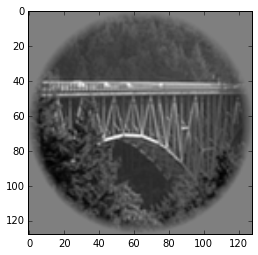

In [6]:
plt.imshow(crcns_stim_dict['stimVal'][0,:,:],cmap='gray')

#### parameters of the gabor stack

In [7]:
n_orientations = 12
deg_per_stimulus = 20
lowest_sp_freq = .2 ##cyc/deg
highest_sp_freq = 4.165
num_sp_freq = 12
pix_per_cycle = 6
complex_cell = True

#### create gabor_feature_map object

In [8]:
gfm = gabor_feature_maps(n_orientations,
                         deg_per_stimulus,
                         (lowest_sp_freq,highest_sp_freq,num_sp_freq),
                         pix_per_cycle=pix_per_cycle,complex_cell=complex_cell)

#### see the table of gabor params

In [9]:
gfm.gbr_table.tail()

,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
139,1.380796,4,2.896880,165.695530,24,0.724220,2.879793
140,1.819705,4,2.198159,218.364562,24,0.549540,2.879793
141,2.398128,4,1.667968,287.775305,24,0.416992,2.879793
142,3.160412,4,1.265658,379.249387,24,0.316414,2.879793
143,4.165000,4,0.960384,499.800000,24,0.240096,2.879793


#### see one of the gabors
note that all gabors have the same size and same number of cycles. the only variation is in the orientation. this
is because when we apply the filters we downsample the images to low frequncy filtering (instead of upsampling the gabors).

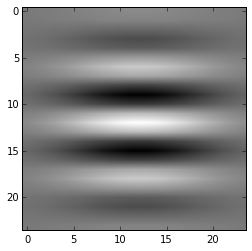

In [10]:
o = 1
plt.imshow(np.real(gfm.filter_stack[o,0,:,:]),cmap='gray')


#### test on a grating

cyc/deg: 2.000000


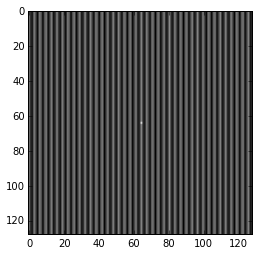

In [11]:
##test. make a horizontal gabor, then filter it with bank of gabors to get sp. freq tuning
test_deg_per_stim = 20.
test_cycles_per_stim = 40. 
print 'cyc/deg: %f' %(test_cycles_per_stim/test_deg_per_stim)
test_stim_size = 128
test_grating = make_gabor(test_cycles_per_stim,np.pi/2.,np.pi/2.,(0,0),2*test_stim_size,test_stim_size)

plt.imshow(test_grating,cmap='gray')

In [12]:
test_feat_dict = gfm.create_feature_maps(test_grating[np.newaxis,np.newaxis,:,:],interp_order=3)

allocating memory for feature maps
constructing feature maps
feature 0 took 0.007874 s.
feature 1 took 0.001990 s.
feature 2 took 0.002811 s.
feature 3 took 0.003250 s.
feature 4 took 0.003288 s.
feature 5 took 0.003802 s.
feature 6 took 0.004998 s.
feature 7 took 0.006425 s.
feature 8 took 0.007543 s.
feature 9 took 0.012029 s.
feature 10 took 0.017928 s.
feature 11 took 0.030309 s.
feature 12 took 0.002498 s.
feature 13 took 0.002355 s.
feature 14 took 0.002844 s.
feature 15 took 0.002347 s.
feature 16 took 0.002491 s.
feature 17 took 0.002882 s.
feature 18 took 0.003681 s.
feature 19 took 0.005296 s.
feature 20 took 0.009000 s.
feature 21 took 0.012848 s.
feature 22 took 0.018935 s.
feature 23 took 0.029493 s.
feature 24 took 0.002933 s.
feature 25 took 0.002708 s.
feature 26 took 0.002994 s.
feature 27 took 0.003090 s.
feature 28 took 0.003151 s.
feature 29 took 0.003658 s.
feature 30 took 0.003703 s.
feature 31 took 0.005492 s.
feature 32 took 0.007329 s.
feature 33 took 0.011112 

##### frequency sensitivity

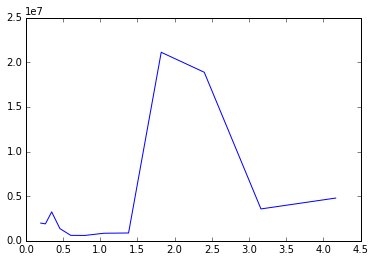

In [13]:
freqs,mean_resp=gfm.sensitivity(test_feat_dict, 'cycles per deg.')
plt.plot(freqs,mean_resp)

Everything depends critically on the pixels per cycle. Without it, you get weird aliasing where the spatial 
frequency tuning has many spurious bumps for higher frequencies. For natural scenes, we seem to get nice 1/f scaling when pix/cyc = 6.

##### orientation sensitivity

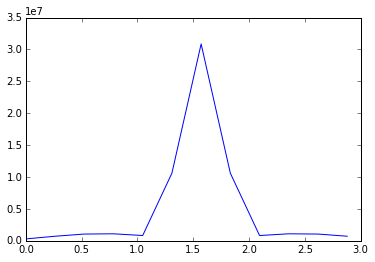

In [14]:
oris,mean_resp=gfm.sensitivity(test_feat_dict, 'orientation')
plt.plot(oris,mean_resp)

#### test on real stimuli

In [15]:
real_feat_dict = gfm.create_feature_maps(crcns_stim_dict['stimTrn'][0:10,np.newaxis,:,:])

allocating memory for feature maps
constructing feature maps
feature 0 took 0.017853 s.
feature 1 took 0.015467 s.
feature 2 took 0.016382 s.
feature 3 took 0.017536 s.
feature 4 took 0.025596 s.
feature 5 took 0.031732 s.
feature 6 took 0.039010 s.
feature 7 took 0.053448 s.
feature 8 took 0.081015 s.
feature 9 took 0.125516 s.
feature 10 took 0.203633 s.
feature 11 took 0.395363 s.
feature 12 took 0.018205 s.
feature 13 took 0.015430 s.
feature 14 took 0.016123 s.
feature 15 took 0.017372 s.
feature 16 took 0.020542 s.
feature 17 took 0.025632 s.
feature 18 took 0.035178 s.
feature 19 took 0.050247 s.
feature 20 took 0.079791 s.
feature 21 took 0.122621 s.
feature 22 took 0.200655 s.
feature 23 took 0.345253 s.
feature 24 took 0.018028 s.
feature 25 took 0.015457 s.
feature 26 took 0.016431 s.
feature 27 took 0.018079 s.
feature 28 took 0.020737 s.
feature 29 took 0.037376 s.
feature 30 took 0.037750 s.
feature 31 took 0.050120 s.
feature 32 took 0.079089 s.
feature 33 took 0.123497 

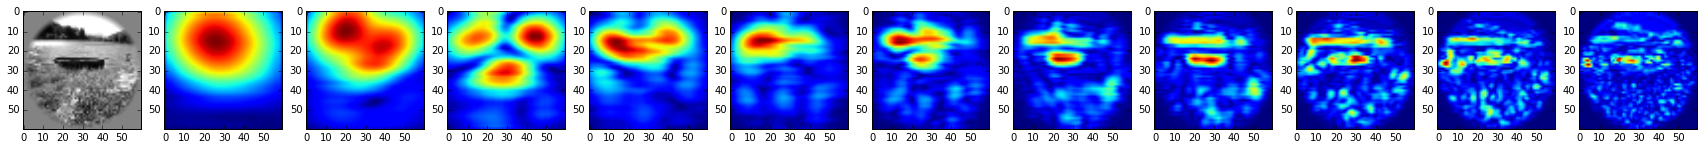

In [16]:
sdx = 9
plt.figure(figsize=(30,60))
num_plots = gfm.num_sp_freq[0]
imshape = (60,60)
plt.subplot(1,num_plots,1)
plt.imshow(resize(crcns_stim_dict['stimTrn'][sdx,:,:],imshape,order=3),cmap='gray')
for pi in np.arange(2,num_plots+1):
    plt.subplot(1,num_plots,pi)
    plt.imshow(resize(real_feat_dict[gfm.gbr_table.index[pi-2]][sdx,0,:,:],imshape,order=3,preserve_range=True))
    
    

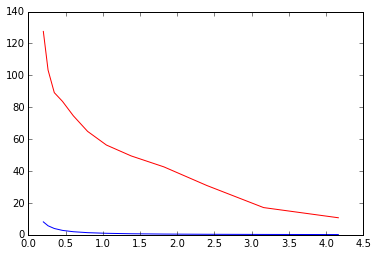

In [17]:
freqs,mean_resp=gfm.sensitivity(real_feat_dict, 'cycles per deg.')
plt.plot(freqs,mean_resp,'r')
plt.plot(freqs, 1./(freqs**1.3),hold=True)

some kind of 1/f spectrum, just as you'd expect.

#### compare to standard method, where the image stays the same size but the gabor changes